In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
# plt.style.use('ggplot')
import seaborn as sns
from enum import Enum
import matplotlib.colors as mcolors
import colorsys
import os

In [3]:
# results = pd.read_csv("../test_results/hyper_sdqlpy_dense_tuning_test_results.csv") 
results = pd.read_csv("../test_results/hyper_sdqlpy_pandas_tpch_direct_optimisations_test_results.csv") 

In [4]:
print(f"Overall Results: {len(results)}")

# Filter for Correct == True and Executed == Yes
results = results[(results.Correct == True) & (results.Executed == "Yes")]
print(f"Correct Results: {len(results)}")

Overall Results: 176
Correct Results: 176


In [5]:
def g_mean(x):
    a = np.log(x)
    return np.exp(a.mean())

def pre_process(df):
    # Sort Query Name column to in-order
    def extract_number(name):
        if isinstance(name, int):
            return name
        else:
            return int(name.split(" ")[1])

    df['Query Number'] = df.apply(lambda row : extract_number(row['Query Number']), axis = 1)
    df = df.sort_values(['Query Number'])

    # Fix the runs column
    def fix_runs(runs):
        new_runs = list(str(str(runs)[1:-1]).split(","))
        for i in range(0, len(new_runs)):
            new_runs[i] = float(new_runs[i].strip())
        return new_runs

    df['Runs'] = df.apply(lambda row : fix_runs(row['Runs']), axis = 1)

    def ignore_first_gmean(runs):
        return g_mean(runs[1:])
    
    def ignore_first_mean(runs):
        return sum(runs[1:]) / len(runs[1:])

    df["Mean"] = df.apply(lambda row : ignore_first_mean(row['Runs']), axis = 1)
    df["Query Type"] = df["Query Name"]
    df = df[["Query Type", "Query Number", "Mean", "Runs"]]
    
    return df

results = pre_process(results)

In [6]:
def make_overall_table(df):
    overall = df.groupby("Query Type").agg(
        overall_mean_runtime=("Mean", g_mean)
    )
    overall = overall.sort_values(by="overall_mean_runtime")
    overall = overall.rename(columns={"overall_mean_runtime": "Overall Mean Runtime (s)"})
    return overall

In [7]:
overall = make_overall_table(results)
overall.head(15)

,Overall Mean Runtime (s)
Query Type,
Hyper DB,0.153907
O1 SDQLpy,0.155856
O4 SDQLpy,0.220752
O2 SDQLpy,0.274375
O3 SDQLpy,0.274924
Naive SDQLpy,0.278308
Pandas Converted + O4 (Hyper DB),0.426387
Pandas Converted (Hyper DB),0.427010


In [8]:
((0.278308 - 0.274924) / 0.278308) * 100

1.2159190537102773

In [9]:
def get_querytype_mean_dict(query_type):
    query_numbers = list(results[results['Query Type'] == query_type].to_dict()['Query Number'].values())
    query_means = list(results[results['Query Type'] == query_type].to_dict()['Mean'].values())

    return dict(zip(query_numbers, query_means))

def percentage_difference(num1, num2):
    return 100 * (abs(num1 - num2) / ((num1 + num2) / 2))

all_type = "O4 SDQLpy"
prev_type = "Naive SDQLpy"

all_runtimes = get_querytype_mean_dict(all_type)
prev_runtimes = get_querytype_mean_dict(prev_type)

slower = 0
faster = 0

for query, all_runtime in all_runtimes.items():
    prev_runtime = prev_runtimes[query]
    perc_diff = round(percentage_difference(all_runtime, prev_runtime), 5)
    if prev_runtime < all_runtime and perc_diff >= 5:
        print(f"For Query {query}, '{all_type}' was more than 5% slower than '{prev_type}'.")
        print(f"\t'{all_type}': {all_runtime}")
        print(f"\t'{prev_type}': {prev_runtime}")
        print(f"\tPercentage difference: {perc_diff}%")
        slower += 1
    elif prev_runtime > all_runtime and perc_diff >= 5:
        print(f"For Query {query}, '{all_type}' was more than 5% faster than '{prev_type}'.")
        print(f"\t'{all_type}': {all_runtime}")
        print(f"\t'{prev_type}': {prev_runtime}")
        print(f"\tPercentage difference: {perc_diff}%")
        faster += 1
        
print(f"{slower} Queries were Slower after Optimising")
print(f"{faster} Queries were Faster after Optimising")

# round(percentage_difference(0.274375, 0.278308), 5)

For Query 2, 'O4 SDQLpy' was more than 5% faster than 'Naive SDQLpy'.
	'O4 SDQLpy': 0.04543347358703613
	'Naive SDQLpy': 0.1019127368927002
	Percentage difference: 76.66198%
For Query 3, 'O4 SDQLpy' was more than 5% faster than 'Naive SDQLpy'.
	'O4 SDQLpy': 0.5106194496154786
	'Naive SDQLpy': 0.6046677589416504
	Percentage difference: 16.86531%
For Query 4, 'O4 SDQLpy' was more than 5% faster than 'Naive SDQLpy'.
	'O4 SDQLpy': 0.5832040309906006
	'Naive SDQLpy': 0.8553495407104492
	Percentage difference: 37.83599%
For Query 5, 'O4 SDQLpy' was more than 5% faster than 'Naive SDQLpy'.
	'O4 SDQLpy': 0.1601255416870117
	'Naive SDQLpy': 0.2751466751098633
	Percentage difference: 52.85021%
For Query 6, 'O4 SDQLpy' was more than 5% faster than 'Naive SDQLpy'.
	'O4 SDQLpy': 0.0580294132232666
	'Naive SDQLpy': 0.06105551719665527
	Percentage difference: 5.08226%
For Query 9, 'O4 SDQLpy' was more than 5% faster than 'Naive SDQLpy'.
	'O4 SDQLpy': 0.501565408706665
	'Naive SDQLpy': 1.1987068176269

In [10]:
0.061738204956054685 / 0.03185625076293945

1.9380248295847466

In [11]:
((0.202112 - 0.189468) / 0.202112) * 100
O1,O2 SDQLpy	

SyntaxError: invalid syntax (3564728750.py, line 2)

In [ ]:
def runtime_reduction(old, new):
    return ((old - new) / old) * 100

runtime_reduction(0.08513712882995605, 0.07212376594543457)

15.285179408050048

In [ ]:
runtime_reduction(0.202112, 0.189468)

6.255937302089938

## Boxplots

In [ ]:
results['Query Type'] = results['Query Type'].replace(
    {
        'Pandas Converted (Hyper DB)': 'Pandas',
        'Pandas Converted + O4 (Hyper DB)': 'O4 Pandas'
    }
)

In [ ]:
results

,Query Type,Query Number,Mean,Runs
0,Hyper DB,1,0.129322,"[0.13045930862426758, 0.1293809413909912, 0.12..."
1,Naive SDQLpy,1,1.295751,"[1.366431713104248, 1.3349874019622803, 1.2851..."
2,O1 SDQLpy,1,0.073416,"[0.07568359375, 0.07184267044067383, 0.0736100..."
3,O2 SDQLpy,1,1.343711,"[1.3827297687530518, 1.3863816261291504, 1.312..."
4,O3 SDQLpy,1,1.333620,"[1.4018220901489258, 1.3590068817138672, 1.331..."
...,...,...,...,...
170,O1 SDQLpy,22,0.027338,"[0.03550386428833008, 0.02771592140197754, 0.0..."
171,O2 SDQLpy,22,0.028643,"[0.039954423904418945, 0.028383493423461914, 0..."
172,O3 SDQLpy,22,0.061738,"[0.07193589210510254, 0.0604250431060791, 0.06..."
173,O4 SDQLpy,22,0.029004,"[0.03833436965942383, 0.02956557273864746, 0.0..."


In [ ]:
# Compare 
compare_groups = [
    ("O4_graph.pdf", ["Naive SDQLpy", "O4 SDQLpy", "Pandas", "O4 Pandas"]),
    ("O1_graph.pdf", ["Naive SDQLpy", "O1 SDQLpy"]),
    ("O2_graph.pdf", ["Naive SDQLpy", "O2 SDQLpy"]),
    ("O3_graph.pdf", ["Naive SDQLpy", "O3 SDQLpy"])
]

In [ ]:
def make_boxplot_graph(original_df, data_labels, filename = None):
    new_df = original_df[original_df["Query Type"].isin(data_labels)]
    # Convert to ms
    new_df['Mean'] = new_df['Mean'].apply(lambda x : x * 1000)
    
    new_df['Query Type'] = new_df['Query Type'].replace(
        {
            'O4 SDQLpy': 'Variable Elimination\nSDQLpy', 
            'O4 Pandas': 'Variable Elimination\nPandas', 
            'O1 SDQLpy': 'Fusion\nSDQLpy', 
            'O2 SDQLpy': 'Update Sum\nSDQLpy', 
            'O3 SDQLpy': 'Dense\nSDQLpy', 
        }
    )

    with sns.axes_style("ticks"):
        sns.set_theme(rc={'figure.figsize':(8,6)})

        ax = sns.boxplot(data=new_df, x="Query Type", y="Mean", color="#D9D9D9", linecolor="#137", linewidth=.75)
        
        ax.set_ylabel("Runtime (ms)")
        ax.set_xlabel("")
        
        # Make axes weightier
        plt.setp(ax.spines.values(), linewidth=1)
        
        for spine in ax.spines.values():
            spine.set_edgecolor('k')
            
        ax.spines[['right', 'top']].set_visible(False)
        
        plt.tight_layout()
    
        if filename != None:
            os.makedirs(os.path.dirname(filename), exist_ok=True)  
            plt.savefig(filename, bbox_inches="tight", transparent=True)
        
        plt.show()

/tmp/ipykernel_748051/3796061260.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df['Mean'] = new_df['Mean'].apply(lambda x : x * 1000)
/tmp/ipykernel_748051/3796061260.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df['Query Type'] = new_df['Query Type'].replace(


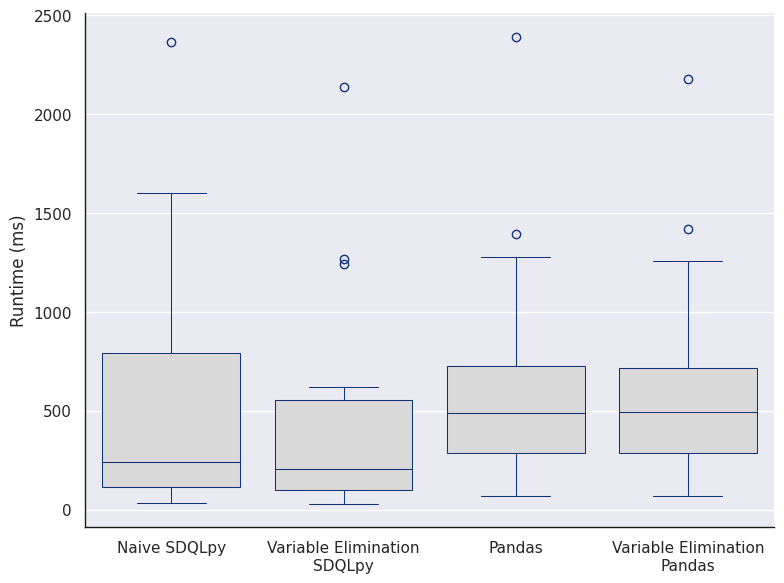

/tmp/ipykernel_748051/3796061260.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df['Mean'] = new_df['Mean'].apply(lambda x : x * 1000)
/tmp/ipykernel_748051/3796061260.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df['Query Type'] = new_df['Query Type'].replace(


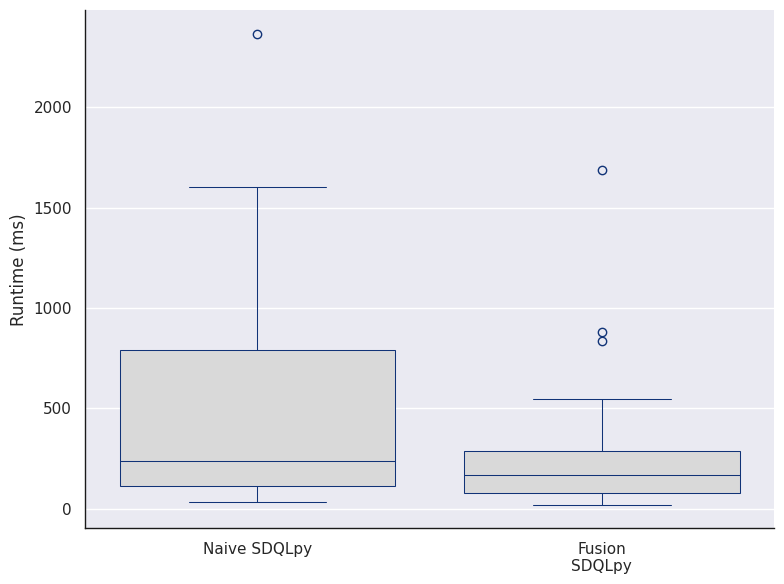

/tmp/ipykernel_748051/3796061260.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df['Mean'] = new_df['Mean'].apply(lambda x : x * 1000)
/tmp/ipykernel_748051/3796061260.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df['Query Type'] = new_df['Query Type'].replace(


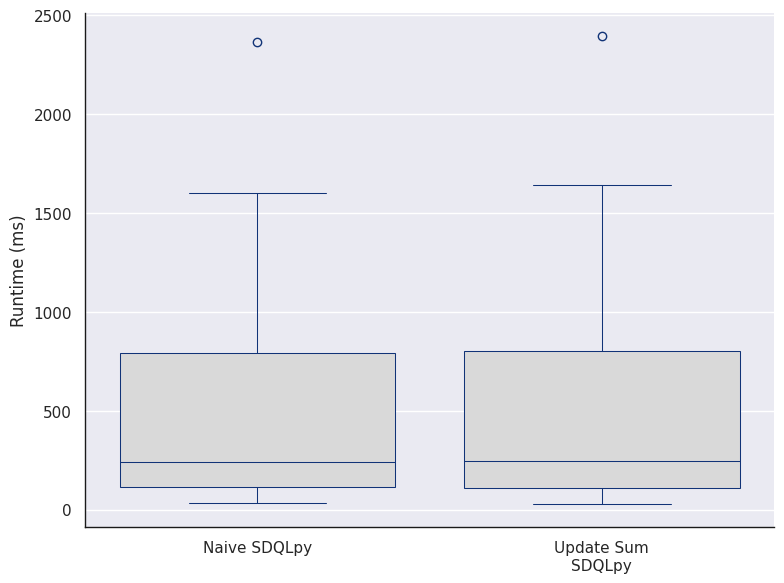

/tmp/ipykernel_748051/3796061260.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df['Mean'] = new_df['Mean'].apply(lambda x : x * 1000)
/tmp/ipykernel_748051/3796061260.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df['Query Type'] = new_df['Query Type'].replace(


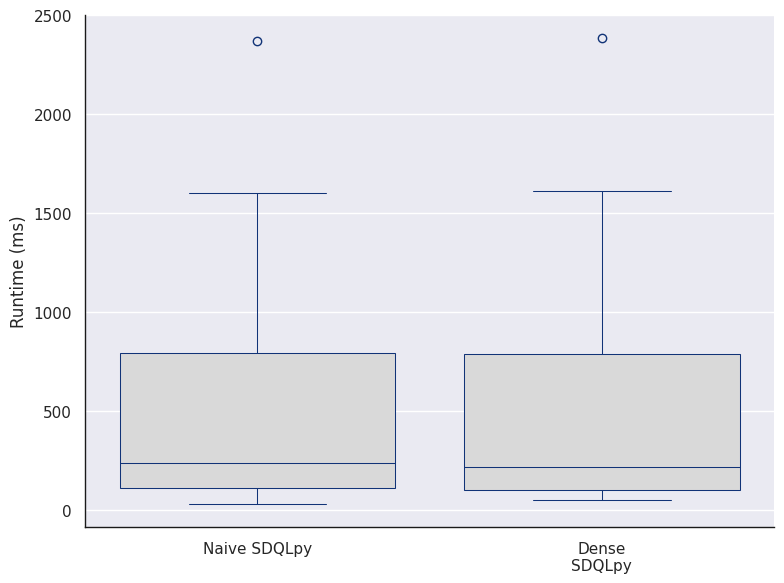

In [ ]:
for filename, data_labels in compare_groups:
    make_boxplot_graph(
        results,
        data_labels,
        f"../analysis_results/y2_report/{filename}"
    )